# 自適應增強分類(Adaptive Boost Classifier)

##### 先引入我們需要的packages

In [1]:
import os 
import numpy as np
import random
import matplotlib.pyplot as plt
from random import choices

# Training Data

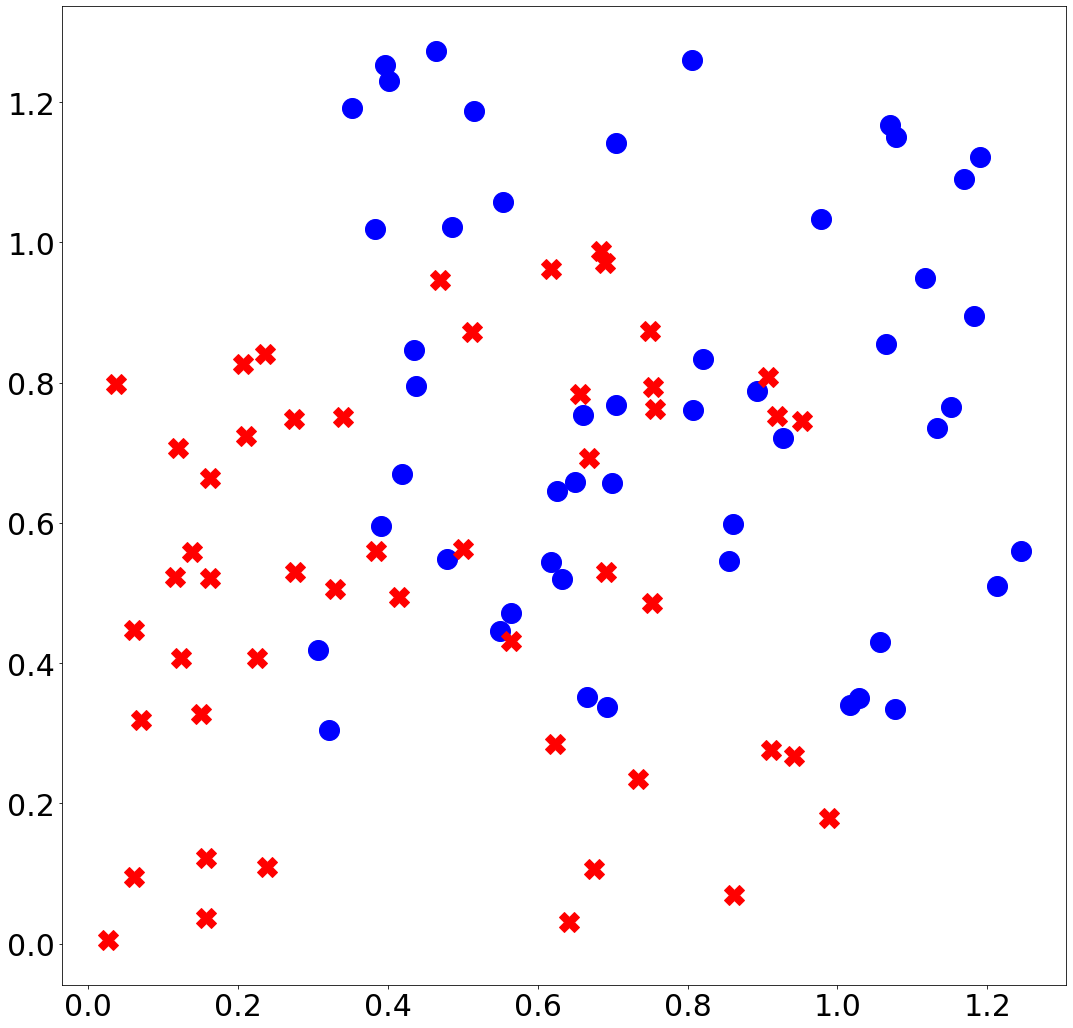

In [8]:
x=np.zeros((100,2))
y=np.zeros(100)
for i in range(0,100): 
    f=-0.1
    if(i<50):
        y[i]=1
        x[i,0]=random.random()+0.3
        x[i,1]=random.random()+0.3
    else:
        y[i]=-1
        x[i,0]=random.random()
        x[i,1]=random.random()
plt.rcParams["figure.figsize"] = (18,18)
plt.plot(x[:50,0],x[:50,1],"bo",markersize=20)
plt.plot(x[50:,0],x[50:,1],"rX",markersize=20)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.show()

# Testing Data

In [9]:
N_test=20
x_test=np.zeros((N_test,2))
y_test=np.zeros(N_test)
for i in range(0,N_test): 
    f=-0.1
    if(i<N_test/2):
        y_test[i]=1
        x_test[i,0]=random.random()+0.3
        x_test[i,1]=random.random()+0.3
    else:
        y_test[i]=-1
        x_test[i,0]=random.random()
        x_test[i,1]=random.random()

# Decision Stump

In [10]:
def Decision_Stump(x,y,D):
    # comp_x0: 用來放橫軸加權錯誤率候選值
    # comp_x1: 用來放縱軸加權錯誤率候選值
    comp_x0=np.zeros(len(y)-1)
    comp_x1=np.zeros(len(y)-1)
    # x0_sort: 所有資料點橫軸座標排序
    # x1_sort: 所有資料點縱軸座標排序
    x0_sort=np.sort(x[:,0])
    x1_sort=np.sort(x[:,1])
    # x0_sort_index:所有資料點橫軸座標排序後所對應的index
    # x1_sort_index:所有資料點縱軸座標排序後所對應的index
    x0_sort_index=np.argsort(x[:,0])
    x1_sort_index=np.argsort(x[:,1])
    # 這裡的演算法核心就是我們以排列好的橫軸和縱標
    # 從第一個資料開始分成兩半，然後並計算impurity值
    for i in range(1,len(y)):
        # 分成左右subtree
        s_left,s_right=x0_sort_index[:i],x0_sort_index[i:]
        # 檢查分到的兩邊為1或為-1
        if(np.count_nonzero(y[s_left]==1)/len(y[s_left])>=0.5):
            class_left,class_right=1,-1
        elif(np.count_nonzero(y[s_right]==1)/len(y[s_right])>=0.5):
            class_left,class_right=-1,1
        comp_x0[i-1]=sum(D[s_left]*(y[s_left]!=class_left))+sum(D[s_right]*(y[s_right]!=class_right))
        # 分成上下subtree
        s_left,s_right=x1_sort_index[:i],x1_sort_index[i:]
        # 檢查分到的兩邊為1或為-1
        if(np.count_nonzero(y[s_left]==1)/len(y[s_left])>=0.5):
            class_left,class_right=1,-1
        elif(np.count_nonzero(y[s_right]==1)/len(y[s_right])>=0.5):
            class_left,class_right=-1,1
        comp_x1[i-1]=sum(D[s_left]*(y[s_left]!=class_left))+sum(D[s_right]*(y[s_right]!=class_right))
    # 回傳分類線和錯誤率
    if(min(comp_x0)<min(comp_x1)):
        x_split=(x0_sort[np.argmin(comp_x0)]+x0_sort[np.argmin(comp_x0)+1])/2
        return x_split,0,min(comp_x0)
    else:
        x_split=(x1_sort[np.argmin(comp_x1)]+x1_sort[np.argmin(comp_x1)+1])/2
        return x_split,1,min(comp_x1)

# Adapative Boost

The training error rate:  0.2
The testing error rate:  0.15


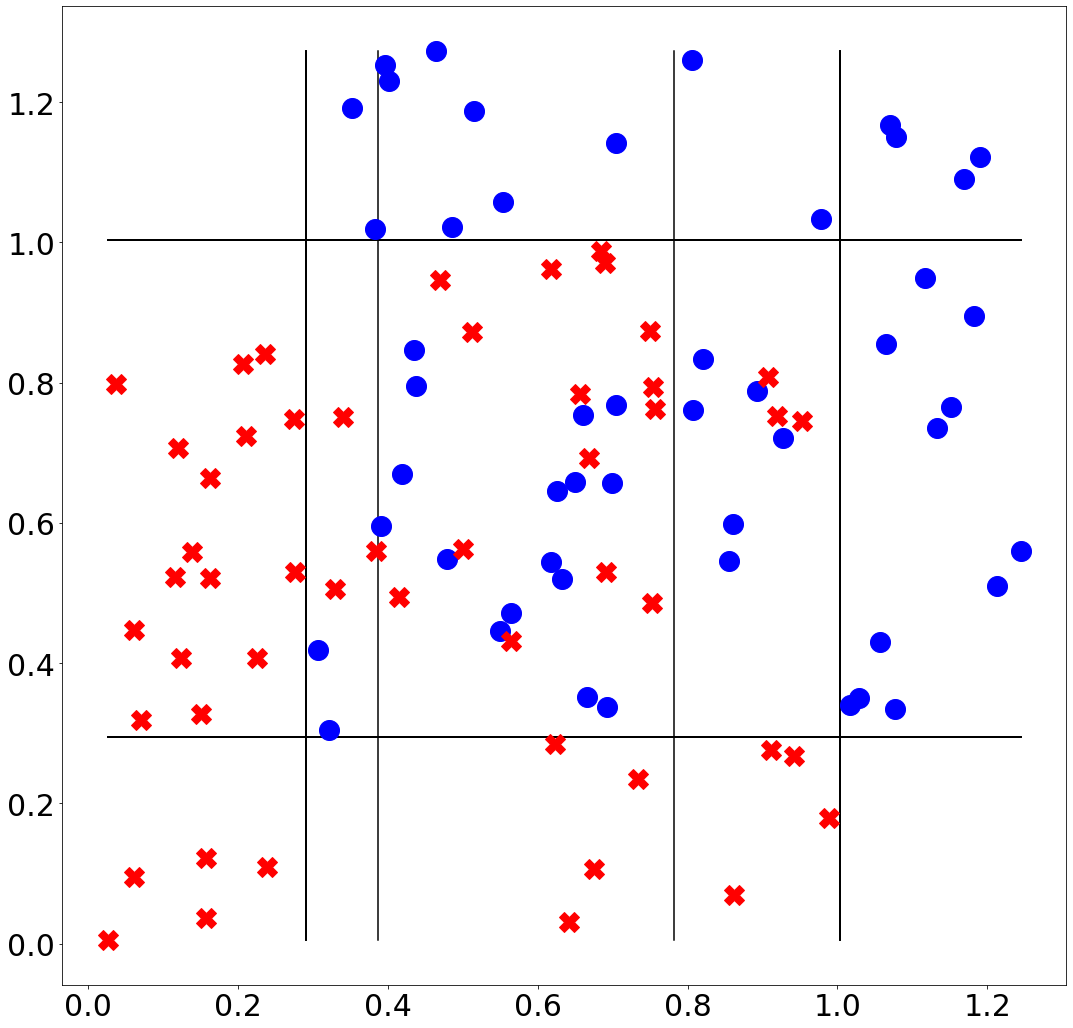

In [11]:
N=100
# T: sub-models數量
T=20
# D:存放權重的矩陣
# a:存放每次回圈所得到的alpha值
D=np.ones(N)/N
new_D=np.ones(N)/N
a=np.zeros(T)
# result用來存放資料最後AdaBoost分類的結果
result=np.zeros(N)
result_test=np.zeros(N_test)
plt.rcParams["figure.figsize"] = (18,18)
# 執行迴圈
for i in range(0,T):
    # 執行弱分類演算法
    x_split,axis,error=Decision_Stump(x,y,D)
    # 劃出分割線
    if(axis==0):
        plt.plot([x_split,x_split],[min(x[:,1]),max(x[:,1])],"k-")
    else:
        plt.plot([min(x[:,0]),max(x[:,0])],[x_split,x_split],"k-")
    # 計算alpha值
    a[i]=0.5*np.log((1-error)/error)
    # 確認分類線劃分的兩邊為1或-1
    temp=y[x[:,axis]<x_split]==1
    if(sum(temp/len(temp))>=0.5):
        cl,cr=1,-1
    else:
        cl,cr=-1,1
    
    left_index=np.array(np.where(x[:,axis]<x_split))
    right_index=np.array(np.where(x[:,axis]>x_split))
    left_index_test=np.array(np.where(x_test[:,axis]<x_split))
    right_index_test=np.array(np.where(x_test[:,axis]>x_split))
    # 四種情況
    # 1.分到其中一邊，且正確 | 2.分到其中一邊，但錯誤 | 3.分到另外一邊，且正確 | 4.分到另外一邊，但錯誤
    new_D[left_index[y[left_index]==cl]]=D[left_index[y[left_index]==cl]]*np.exp(-a[i])/sum(D)
    new_D[left_index[y[left_index]!=cl]]=D[left_index[y[left_index]!=cl]]*np.exp(a[i])/sum(D)
    new_D[right_index[y[right_index]==cr]]=D[right_index[y[right_index]==cr]]*np.exp(-a[i])/sum(D)
    new_D[right_index[y[right_index]!=cr]]=D[right_index[y[right_index]!=cr]]*np.exp(a[i])/sum(D)
    # 每次計算後加乘結果
    result[left_index]+=cl*a[i]
    result[right_index]+=cr*a[i]
    result_test[left_index_test]+=cl*a[i]
    result_test[right_index_test]+=cr*a[i]
    # 更新權重
    D=new_D
# 輸出結果
print("The training error rate: ",round(1-sum(np.sign(result)==y)/N,2))
print("The testing error rate: ",round(1-sum(np.sign(result_test)==y_test)/N_test,2))
plt.plot(x[:50,0],x[:50,1],"bo",markersize=20)
plt.plot(x[50:,0],x[50:,1],"rX",markersize=20)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.show()